<a href="https://colab.research.google.com/github/Tyler-Hattori/fretboard_ai/blob/third/fretboard_transformer_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### import

In [20]:
import numpy as np
from numpy import random
import torch
from torch import nn
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import MultiHeadAttention, LayerNormalization, Layer, Dense, Dropout, Flatten, Embedding, Add
import os
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# seq2key encoder

### helper functions

In [2]:
def next_key(chords):
  next = [[[0 for i in range(3)] for j in range(6)] for k in range(6)]
  for i in range(6):
    for j in range(6):
      next[i][j] = chords[i][j].copy()
      next[i][j][2] = next[i][j][2] + 1
    if next[i][4][2] == 12:
      next[i].pop()
      next[i].insert(0,next[i][4].copy())
      next[i][0][2] = next[i][0][2] - 12
  return next

In [3]:
def tokenize(chord):
  return chord[0]*5*15 + chord[1]*15 + chord[2] + 1

In [4]:
def token2chord(token):
  token = token - 1
  t1 = int(token/(5*15))
  t2 = int((token-(t1*5*15))/15)
  t3 = token - t1*5*15 - t2*15
  return [t1,t2,t3]

In [5]:
def chord2name(chord):
  estring = ['E','F','F#','G','G#','A','A#','B','C','C#','D','D#','E','F','F#','G','A','A#']
  astring = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#','A','A#','B','C','C#','D']
  dstring = ['D','D#','E','F','F#','G','G#','A','A#','B','C','C#','D','D#','E','F','F#','G']
  name = ''
  color = chord[0]
  shape = chord[1]
  bar = chord[2]
  if shape == 0: name = name + astring[bar+3]
  elif shape == 1: name = name + astring[bar]
  elif shape == 2: name = name + estring[bar+3]
  elif shape == 3: name = name + estring[bar]
  elif shape == 4: name = name + dstring[bar]
  if color == 1: name = name + 'm'
  return name

In [6]:
def name2token(name,shape):
  key_index = key_names.index(name)
  chord = [int(key_index > 11), shape, -1]
  if shape == 0: chord[2] = np.mod(key_index,12)
  elif shape == 1: chord[2] = np.mod(key_index,12) + 3
  elif shape == 2: chord[2] = np.mod(key_index,12) + 5
  elif shape == 3: chord[2] = np.mod(key_index,12) + 8
  elif shape == 4: chord[2] = np.mod(key_index,12) + 10
  else: print('shape should be between 0 and 4')
  return tokenize(chord)

In [7]:
def mask(seq):
  temp = seq[:]
  for i in range(len(seq)):
    if (random.randint(100)+1)/100.0 <= mask_input_prob:
      temp[i] = mute_token
  return temp

In [8]:
def report(index,inputs,outputs):
  for i in range(N):
    print(chord2name(token2chord(inputs[index][i])))
  print('key is ' + key_names[outputs[index]])

### params

In [9]:
N = 4
D = 512
H = 8
L = 6
dff = D*4
batch_size = 32
epochs = 20
vocab_length = tokenize([1,4,14])
mute_token = 0
output_dim = 12
mask_input_prob = 0.05
dropout_rate = 0.1
key_names = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B','Cm','C#m','Dm','D#m','Em','Fm','F#m','Gm','G#m','Am','A#m','Bm']

### seq2key dataset

In [10]:
def make_seq2key_dataset():
  # specify csf chord representations
  c = [[[0,0,0],[0,1,3],[0,2,5],[0,3,8],[0,4,10],[0,0,12]], # 1
      [[1,4,0],[1,0,2],[1,1,5],[1,2,7],[1,3,10],[1,4,12]], # 2
      [[1,3,0],[1,4,2],[1,0,4],[1,1,7],[1,2,9],[1,3,12]], # 3
      [[0,3,1],[0,4,3],[0,0,5],[0,1,8],[0,2,10],[0,3,13]], # 4
      [[0,2,0],[0,3,3],[0,4,5],[0,0,7],[0,1,10],[0,2,12]], # 5
      [[1,1,0],[1,2,2],[1,3,5],[1,4,7],[1,0,9],[1,1,12]]] # 6
  csharp = next_key(c)
  d = next_key(csharp)
  dsharp = next_key(d)
  e = next_key(dsharp)
  f = next_key(e)
  fsharp = next_key(f)
  g = next_key(fsharp)
  gsharp = next_key(g)
  a = next_key(gsharp)
  asharp = next_key(a)
  b = next_key(asharp)
  keys = [c,csharp,d,dsharp,e,f,fsharp,g,gsharp,a,asharp,b]

  # tokenize inputs
  for i in range(len(keys)):
    for j in range(6):
      for k in range(6):
        keys[i][j][k] = tokenize(keys[i][j][k].copy())

  # specify progressions
  major_progs = [[1,1,4,3],[1,3,4,6],[1,3,6,4],[1,4,2,5],[1,4,5,4],[1,4,5,5],[1,4,6,5],[1,5,1,4],[1,5,4,6],
                    [1,5,6,2],[1,5,6,3,4,1,4,5],[1,5,6,3,4],[1,5,6,4],[1,5,6,5],[1,6,1,4],[1,6,2,4],[1,6,2,5],[1,6,4,3],
                    [1,6,4,5],[2,4,5,5],[2,4,6,5],[2,5,1,1],[2,5,1,4],[3,6,4,1],[4,1,2,6],[4,1,3,4],[4,1,5,6],[4,4,1,5],
                    [4,6,1,5],[4,6,3,1],[4,6,4,6],[5,1,6,5],[5,4,6,1],[5,6,4,1],[6,2,5,1],[6,4,1,5],[6,5,4,5,2,5,1,1],[6,5,4,5]]
  minor_progs = [[6,1,2,4],[6,1,5,4],[6,2,1,4],[6,2,3,2],[6,2,3,3],[6,2,4,3],[6,2,5,6],
                          [6,3,2,5],[6,4,1,5],[6,4,2,1],[6,4,2,3],[6,4,5,3],[6,4,5,5],[6,5,6,3,1,5,6,3,6],[6,5,6,3],
                          [6,5,3,4],[6,5,4,1,2,4,5,6],[6,5,4,1],[6,5,4,5],[2,6,3,4],[2,1,5,6],
                          [2,3,4,5],[2,4,3,5],[2,4,5,6],[3,6,2,5],[3,2,6,6],[3,4,1,6],[3,4,3,6],[4,6,3,1],[4,6,3,3],[4,1,6,3],
                          [4,2,6,3],[4,4,6,5],[4,5,6,1],[4,5,3,1],[5,2,3,6],[5,2,5,6]]

  # organize inputs and outputs
  # input: sequence of N tokens in a given key
  # output: one of 12 possible key labels
  prog_iterations = 200
  major_dataset = [[],[]]
  minor_dataset = [[],[]]
  for k in range(len(keys)):
    key = k
    for prog in range(len(major_progs)):
      for iteration in range(prog_iterations):
        sequence = [mute_token]*N
        for n in range(N):
          voicing_index = random.randint(6)
          sequence[n] = keys[key][major_progs[prog][n%len(major_progs[prog])]-1][voicing_index]
        major_dataset[0].append(sequence)
        major_dataset[1].append(key)
    for prog in range(len(minor_progs)):
      for iteration in range(prog_iterations):
        sequence = [mute_token]*N
        for n in range(N):
          voicing_index = random.randint(6)
          sequence[n] = keys[key][minor_progs[prog][n%len(minor_progs[prog])]-1][voicing_index]
        minor_dataset[0].append(sequence)
        minor_dataset[1].append(key)
  dataset = [major_dataset,minor_dataset]

  # print length of dataset
  num_sequences = len(dataset[0][0]) + len(dataset[1][0])
  print('seq2key dataset size: ' + str(num_sequences))

  # randomly "mute" (mask) some notes in the input sequence so the model learns how to fill in the blanks. This is directly inspired by the BERT model
  inputs = []
  outputs = []
  for i in range(num_sequences):
    color = random.randint(2)
    if len(dataset[color][0]) == 0:
      color = (color+1)%2
    rand_sample_index = random.randint(len(dataset[color][0]))
    #input_seq = mask(dataset[color][0][rand_sample_index]) # masking not currently implemented
    input_seq = dataset[color][0][rand_sample_index].copy()
    #output_seq = dataset[color][0][rand_sample_index] # masking not currently implemented
    output_key = dataset[color][1][rand_sample_index]
    inputs.append(input_seq)
    outputs.append(output_key)
    dataset[color][0].pop(rand_sample_index)
    dataset[color][1].pop(rand_sample_index)

  # convert inputs and outputs to tensors
  inputs = tf.convert_to_tensor(inputs, dtype=tf.int32)
  outputs = tf.convert_to_tensor(outputs, dtype=tf.int32)
  print()
  print('Shape of the input tensors: ' + str(tf.shape(inputs)))
  print('Shape of the output tensors: ' + str(tf.shape(outputs)))
  print()

  # show example
  idx = 8
  print('Input example: ' + str(inputs[idx].numpy()))
  print('Resulting output: ' + str(outputs[idx].numpy()))
  print()
  print('Example corresponds to:')
  report(idx,inputs,outputs)

  return inputs, outputs

In [11]:
seq_inputs, key_outputs = make_seq2key_dataset()

seq2key dataset size: 180000

Shape of the input tensors: tf.Tensor([180000      4], shape=(2,), dtype=int32)
Shape of the output tensors: tf.Tensor([180000], shape=(1,), dtype=int32)

Input example: [ 72 107  14 137]
Resulting output: 6

Example corresponds to:
C#
G#m
C#
D#m
key is F#


### seq2key model

Positional embedding example:

Input: [[ 31 121   1  87]]

Embedding: [[[-0.4787677   0.81618625 -0.4552399  ...  1.4700271   0.23652792
    1.6693447 ]
  [ 1.4760611   1.3470466   0.960685   ...  0.4200011  -0.06885052
    1.0796115 ]
  [ 1.7385815  -0.08630764  0.09589356 ...  0.9490443   0.92511916
    1.9171821 ]
  [-0.2454706  -0.4176969   1.047102   ...  1.2039275   2.0701857
    2.0268266 ]]]

Embedding shape: (1, 4, 512)



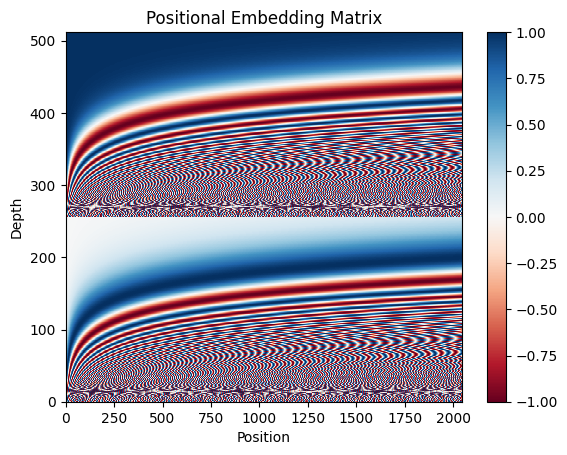


Shape after Self Attention: (1, 4, 512)

Shape after Encoder Feed Forward Layer: (1, 4, 512)


seq2key initial test:

Input example: [ 72 107  14 137]
True output: 6

Example corresponds to:
C#
G#m
C#
D#m
key is F#

seq2key softmax output: [[0.12524945 0.09199105 0.04667199 0.310563   0.04384209 0.03553117
  0.1399457  0.05306958 0.04557363 0.05018569 0.02668966 0.03068696]]
seq2key guess: D#
True output is F#

Model: "seq2_key"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 s2k_positional_embedding_1  multiple                  76800     
  (S2KPositionalEmbedding)                                       
                                                                 
 s2k_encoder_1 (S2KEncoder)  multiple                  10503168  
                                                                 
 s2k_encoder_2 (S2KEncoder)  multiple                  10503168  
                                      

In [12]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

class S2KPositionalEmbedding(Layer):
  def __init__(self, vocab_size=vocab_length, dim_model=D):
    super().__init__()
    self.d_model = dim_model
    self.embedding = Embedding(input_dim=vocab_size, output_dim=dim_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=dim_model)

  def call(self, x):
    chords = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :chords, :]
    return x

# check position embedding
a = S2KPositionalEmbedding()
a_emb = a(tf.convert_to_tensor(seq_inputs[0:1], dtype=tf.int32))
print('Positional embedding example:')
print()
print('Input: ' + str(seq_inputs[0:1].numpy()))
print()
print('Embedding: ' + str(a_emb.numpy()))
print()
print('Embedding shape: ' + str(a_emb.shape))
print()

# check the positional encoding
pos_encoding = positional_encoding(length=2048, depth=512)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.title('Positional Embedding Matrix')
plt.colorbar()
plt.show()

class S2KBaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

class S2KGlobalSelfAttention(S2KBaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    return self.layernorm(x)

# check gsa
sample_gsa = S2KGlobalSelfAttention(num_heads=2, key_dim=512)
print()
print('Shape after Self Attention: ' + str(sample_gsa(a_emb).shape))
print()

class S2KFeedForward(Layer):
  def __init__(self, dim_model=D, dim_mlp=dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      Dense(dim_mlp, activation='relu'),
      Dense(dim_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return self.layer_norm(x)

class S2KEncoder(Layer):
  def __init__(self,*, dim_model=D, num_heads=H, dim_mlp=dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = S2KGlobalSelfAttention(
        num_heads=num_heads,
        key_dim=dim_model,
        dropout=dropout_rate)
    self.mlp = S2KFeedForward(dim_model=dim_model, dim_mlp=dim_mlp)

  def call(self, x):
    x = self.self_attention(x)
    x = self.mlp(x)
    return x

# check encoder mlp
sample_encoder = S2KEncoder(dim_model=D, num_heads=H, dim_mlp=dff)
print('Shape after Encoder Feed Forward Layer: ' + str(sample_encoder(a_emb).shape))
print()

class Seq2Key(tf.keras.Model):
    def __init__(self, *, dim_model=D, seq_length=N, dim_mlp=dff, L=L, dropout_rate=dropout_rate):
        super().__init__()
        self.dim_model = dim_model
        self.L = L

        self.embed = S2KPositionalEmbedding()
        self.encoder_layers = [S2KEncoder() for _ in range(L)]
        self.dropout = Dropout(dropout_rate)

        self.mlp_head = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])

    def call(self, x): # x is (None, 6*N) where None refers to batch size
        x = self.embed(x) # (None, N, dim_model)
        x = self.dropout(x)
        for i in range(self.L): x = self.encoder_layers[i](x)

        flatten = Flatten()
        x = flatten(x) # (None, N*dim_model)
        pred = self.mlp_head(x) # (None, 12)

        pred = tf.nn.softmax(pred)

        return pred

# initialize seq2key object
seq2key = Seq2Key()
print()
print('seq2key initial test:')
print()
idx = 8
print('Input example: ' + str(seq_inputs[idx].numpy()))
print('True output: ' + str(key_outputs[idx].numpy()))
print()
print('Example corresponds to:')
report(idx,seq_inputs,key_outputs)
print()
soft = seq2key(tf.convert_to_tensor(seq_inputs[idx:idx+1], dtype=tf.int32))
print('seq2key softmax output: ' + str(soft.numpy()))
print('seq2key guess: ' + key_names[int(tf.math.argmax(soft,1))])
print('True output is ' + key_names[int(key_outputs[idx:idx+1])])
print()

seq2key.summary()

### seq2key training

Training inputs: tf.Tensor(
[[ 31 121   1  87]
 [ 89  33  63  35]
 [ 88  22  47 141]
 ...
 [144   9  65  32]
 [ 69  47  96 143]
 [ 18  25  84  25]], shape=(132800, 4), dtype=int32)

Training outputs: tf.Tensor([ 7  4 10 ...  1  5 11], shape=(132800,), dtype=int32)



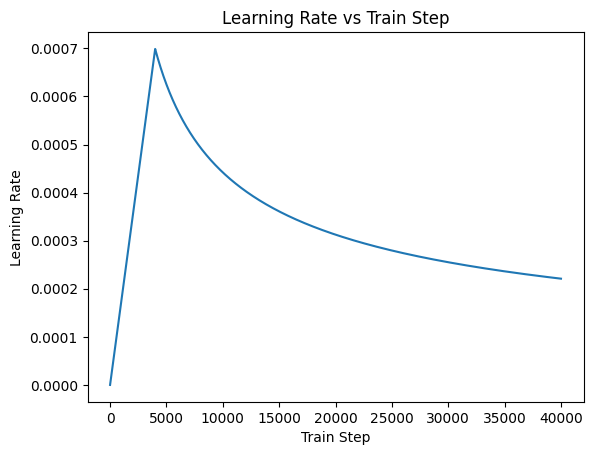

In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, dim_model=D, warmup_steps=4000):
    super().__init__()

    self.dim_model = dim_model
    self.dim_model = tf.cast(self.dim_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.dim_model) * tf.math.minimum(arg1, arg2)

# create optimizer
learning_rate = CustomSchedule(dim_model=D)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# plot learning rate
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.title('Learning Rate vs Train Step')
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

# make batches
train_len = 132800
val_len = 14784
test_len = val_len
train_inputs = seq_inputs[:train_len]
train_outputs = key_outputs[:train_len]
train_outputs = tf.reshape(train_outputs,-1)
val_inputs = seq_inputs[train_len:train_len+val_len]
val_outputs = key_outputs[train_len:train_len+val_len]
val_outputs = tf.reshape(val_outputs,-1)
print('Training inputs: ' + str(train_inputs))
print()
print('Training outputs: ' + str(train_outputs))
print()
test_inputs = seq_inputs[train_len+val_len:train_len+val_len+test_len]
test_outputs = key_outputs[train_len+val_len:train_len+val_len+test_len]

# define loss and accuracy functions
def loss(truths, preds):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
  loss = loss_object(truths, preds)
  loss = tf.reduce_sum(loss)/N
  return loss

def key_accuracy(truths, preds):
  k_preds = tf.math.argmax(preds,1)
  truths = tf.cast(truths,tf.int64)
  match = truths == k_preds
  match = tf.cast(match, dtype=tf.int32)
  return tf.reduce_sum(match)/tf.size(match)

# compile model
seq2key.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])

In [34]:
# train model
seq2key.fit(train_inputs, train_outputs, epochs = epochs, validation_data = (val_inputs, val_outputs))

Epoch 1/20
4150/4150 [==============================] - 178s 41ms/step - loss: 4.3648 - accuracy: 0.8062 - val_loss: 2.2178 - val_accuracy: 0.9131
Epoch 2/20
4150/4150 [==============================] - 169s 41ms/step - loss: 2.2638 - accuracy: 0.9044 - val_loss: 1.6058 - val_accuracy: 0.9323
Epoch 3/20
4150/4150 [==============================] - 181s 44ms/step - loss: 1.3021 - accuracy: 0.9438 - val_loss: 0.6937 - val_accuracy: 0.9655
Epoch 4/20
4150/4150 [==============================] - 174s 42ms/step - loss: 0.9268 - accuracy: 0.9595 - val_loss: 0.7905 - val_accuracy: 0.9642
Epoch 5/20
4150/4150 [==============================] - 173s 42ms/step - loss: 0.7707 - accuracy: 0.9663 - val_loss: 0.6131 - val_accuracy: 0.9736
Epoch 6/20
4150/4150 [==============================] - 160s 39ms/step - loss: 0.6800 - accuracy: 0.9697 - val_loss: 0.4572 - val_accuracy: 0.9805
Epoch 7/20
4150/4150 [==============================] - 170s 41ms/step - loss: 0.6108 - accuracy: 0.9734 - val_loss: 0

In [35]:
# save the weights
seq2key.save_weights('/content/drive/My Drive/Colab/seq2key')

### seq2key testing

In [36]:
# upload model weights
temp_model = Seq2Key()
temp_model.load_weights('/content/drive/My Drive/Colab/seq2key')
print()

# test accuracy on arbitrary batch of input sequences
idx = 714 # random
bch = 320 # random
preds = temp_model(tf.convert_to_tensor(seq_inputs[idx:idx+bch], dtype=tf.int32))
truths = key_outputs[idx:idx+bch]
print('The model is ' + str(100*key_accuracy(truths,preds).numpy()) + '% accurate classifying the key of inputs ' + str(idx) + ' to ' + str(idx+bch))
print()

# test specific input sequence
print('seq2key test:')
print()
idx = 861 # random
print('Test input: ' + str(seq_inputs[idx].numpy()))
print('Key label: ' + str(key_outputs[idx].numpy()))
print()
print('This corresponds to:')
report(idx,seq_inputs,key_outputs)
print()
soft = temp_model(tf.convert_to_tensor(seq_inputs[idx:idx+1], dtype=tf.int32))
print('seq2key softmax output: ' + str(soft.numpy()))
print('seq2key guess: ' + key_names[int(tf.math.argmax(soft,1))])
print()

# test model on user-defined input sequence
seq = ['C','F','G','G']
print('User-defined input sequence: ' + str(seq))
seq = [name2token(seq[i],0) for i in range(len(seq))]
print()
print('Tokenized: ' + str(seq))
print()
soft = temp_model(tf.convert_to_tensor([seq], dtype=tf.int32))
print('seq2key softmax output: ' + str(soft.numpy()))
print()
print('seq2key guess: ' + key_names[int(tf.math.argmax(soft,1))])
print()
temp_model.summary()


The model is 99.6875% accurate classifying the key of inputs 714 to 1034

seq2key test:

Test input: [ 82  93 138  33]
Key label: 2

This corresponds to:
F#m
Bm
Em
A
key is D

seq2key softmax output: [[6.8902556e-15 1.1242377e-14 9.9998200e-01 1.3945570e-17 1.2277600e-12
  4.9968811e-14 1.8747132e-18 1.7185313e-05 9.1414054e-10 8.2929705e-07
  2.7606781e-17 9.5584957e-11]]
seq2key guess: D

User-defined input sequence: ['C', 'F', 'G', 'G']

Tokenized: [1, 6, 8, 8]

seq2key softmax output: [[9.9964690e-01 9.0181459e-07 3.7153672e-10 6.8415687e-08 3.4467286e-13
  1.1288535e-05 2.8924111e-04 5.1442683e-05 9.6587113e-11 9.1396222e-12
  1.4051834e-11 1.1704442e-10]]

seq2key guess: C

Model: "seq2_key_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 s2k_positional_embedding_4  multiple                  76800     
  (S2KPositionalEmbedding)                                       
                          

# tab2chord encoder

### params

In [624]:
N = 6 # guitar tab input
D = 512
H = 8
L = 6
dff = D*4
batch_size = 32
epochs = 20
mute_token = 25
extra_tokens = [mute_token]
vocab_length = 24 + len(extra_tokens)
output_dim = 15 # csf output
mute_string_prob = 0.05
dropout_rate = 0.1
key_names = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B','Cm','C#m','Dm','D#m','Em','Fm','F#m','Gm','G#m','Am','A#m','Bm']

### helper functions

In [625]:
def chord2tab(chord,mute_prob=mute_string_prob):
  m = mute_token
  tab = [m for i in range(6)]
  color = chord[0]
  shape = chord[1]
  fret = chord[2]

  if color == 0: # major chords
    if shape == 0: tab = [m,3,2,0,1,0]
    elif shape == 1: tab = [m,0,2,2,2,0]
    elif shape == 2: tab = [3,2,0,0,3,3]
    elif shape == 3: tab = [0,2,2,1,0,0]
    elif shape == 4: tab = [m,m,0,2,3,2]
  elif color == 1: # minor chords
    if shape == 0: tab = [m,3,1,0,1,m]
    elif shape == 1: tab = [m,0,2,2,1,0]
    elif shape == 2: tab = [3,1,0,0,3,3]
    elif shape == 3: tab = [0,2,2,0,0,0]
    elif shape == 4: tab = [m,m,0,2,3,1]

  tab = [tab[i] if random.rand() > mute_prob else m for i in range(6)]

  return [tab[i] + fret if tab[i] != m else m for i in range(6)]

### tab2chord dataset

In [626]:
def make_tab2chord_dataset():
  # specify csf chord representations
  c = [[[0,0,0],[0,1,3],[0,2,5],[0,3,8],[0,4,10],[0,0,12]], # 1
      [[1,4,0],[1,0,2],[1,1,5],[1,2,7],[1,3,10],[1,4,12]], # 2
      [[1,3,0],[1,4,2],[1,0,4],[1,1,7],[1,2,9],[1,3,12]], # 3
      [[0,3,1],[0,4,3],[0,0,5],[0,1,8],[0,2,10],[0,3,13]], # 4
      [[0,2,0],[0,3,3],[0,4,5],[0,0,7],[0,1,10],[0,2,12]], # 5
      [[1,1,0],[1,2,2],[1,3,5],[1,4,7],[1,0,9],[1,1,12]]] # 6
  csharp = next_key(c)
  d = next_key(csharp)
  dsharp = next_key(d)
  e = next_key(dsharp)
  f = next_key(e)
  fsharp = next_key(f)
  g = next_key(fsharp)
  gsharp = next_key(g)
  a = next_key(gsharp)
  asharp = next_key(a)
  b = next_key(asharp)
  keys = [c,csharp,d,dsharp,e,f,fsharp,g,gsharp,a,asharp,b]

  # store as tablature
  desired_dataset_length = 180000
  cycles = int(desired_dataset_length/(12*6*6))
  tabs = np.zeros((cycles,12,6,6,6))
  chords = np.zeros((cycles,12,6,6,3)) # output will be in csf representation
  for l in range(cycles):
    for i in range(len(keys)):
      for j in range(6):
        for k in range(6):
          tabs[l][i][j][k] = chord2tab(keys[i][j][k].copy())
          chords[l][i][j][k] = keys[i][j][k]

  # reshape as lists of csf representations
  tabs = np.reshape(tabs, (tabs.shape[0]*tabs.shape[1]*tabs.shape[2]*tabs.shape[3],6))
  chords = np.reshape(chords, (len(chords)*len(chords[0])*len(chords[0][0])*len(chords[0][0][0]),3))

  # convert inputs and outputs to tensors
  inputs = tf.convert_to_tensor(tabs, dtype=tf.int32)
  outputs = tf.convert_to_tensor(chords, dtype=tf.int32)
  print()
  print('Shape of the input tensors: ' + str(tf.shape(inputs)))
  print('Shape of the output tensors: ' + str(tf.shape(outputs)))
  print()

  # show example
  idx = 8
  print('Input example: ' + str(inputs[idx].numpy()))
  print('Resulting output: ' + str(outputs[idx].numpy()))
  print()
  print('Output corresponds to ' + chord2name(outputs[idx]))

  return inputs, outputs

In [627]:
tab_inputs, chord_outputs = make_tab2chord_dataset()


Shape of the input tensors: tf.Tensor([179712      6], shape=(2,), dtype=int32)
Shape of the output tensors: tf.Tensor([179712      3], shape=(2,), dtype=int32)

Input example: [25  5  7  7  6  5]
Resulting output: [1 1 5]

Output corresponds to Dm


### tab2chord model

Positional embedding example:

Input: [[25  3  2  0  1  0]]

Embedding: [[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.00000000e+00
    1.00000000e+00  1.00000000e+00]
  [ 4.84130919e-01 -2.58271039e-01  2.72474647e-01 ...  7.56177902e-02
    2.02316070e+00  1.49635935e+00]
  [ 1.41492987e+00  5.04086614e-02  6.15874171e-01 ...  1.55584693e+00
    8.01460683e-01  7.38992453e-01]
  [-2.91948169e-02  8.50350678e-01  3.25751543e-01 ...  1.57284713e+00
    1.17228818e+00  1.53511095e+00]
  [-3.08159322e-01 -1.09105921e+00 -6.89899325e-01 ...  1.71719003e+00
    1.45850396e+00  9.38123822e-01]
  [-1.12923908e+00 -3.88589501e-01 -1.01525891e+00 ...  1.57284713e+00
    1.17228806e+00  1.53511083e+00]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.00000000e+00
    1.00000000e+00  1.00000000e+00]
  [ 4.84130919e-01 -2.58271039e-01  2.72474647e-01 ...  7.56177902e-02
    2.02316070e+00  1.49635935e+00]
  [ 9.09297407e-01  9.36414719e-01  9.58144367e-01 ...  1.00000000e+00

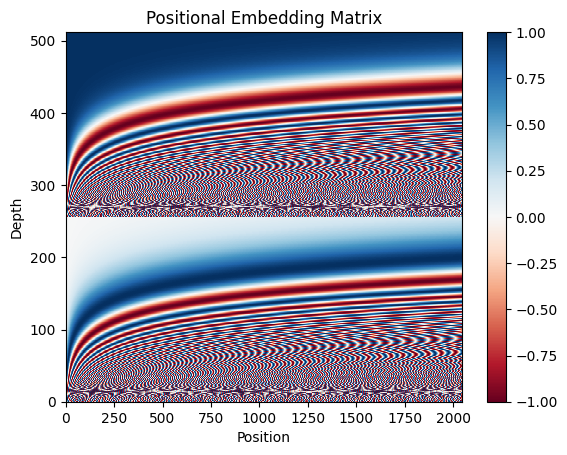


Shape after Self Attention: (32, 6, 512)

Shape after Encoder Feed Forward Layer: (32, 6, 512)

Output shape of the model: (32, 3, 15)

tab2chord initial test:

Input example: [25  5  7  7  6  5]
True output: [1 1 5]

Output corresponds to Dm

tab2chord softmax output: 
color: tf.Tensor(
[0.03927072 0.03230787 0.04441507 0.24466296 0.06658653 0.01398158
 0.01424304 0.15682659 0.08037208 0.03009968 0.1246664  0.01047348
 0.10059155 0.01718341 0.02431908], shape=(15,), dtype=float32)
shape: tf.Tensor(
[0.02689824 0.05114638 0.02088038 0.04619145 0.0465247  0.05245396
 0.26431206 0.01612292 0.07044058 0.27095172 0.05769065 0.00942241
 0.01768072 0.02151111 0.02777276], shape=(15,), dtype=float32)
fret: tf.Tensor(
[0.15119532 0.03068291 0.01095628 0.06204691 0.04410468 0.30357602
 0.01607122 0.18943015 0.03773881 0.00733302 0.02387873 0.05127414
 0.01408376 0.02584505 0.03178293], shape=(15,), dtype=float32)

tab2chord guess: [3, 9, 5]
guess corresponds to 

True output is Dm

Model: "tab

In [628]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

class T2CPositionalEmbedding(Layer):
  def __init__(self, vocab_size=vocab_length, dim_model=D):
    super().__init__()
    self.d_model = dim_model
    self.embedding = Embedding(input_dim=vocab_size, output_dim=dim_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=dim_model)

  def call(self, x):
    chords = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :chords, :]
    return x

# check position embedding
a = T2CPositionalEmbedding()
a_emb = a(tf.convert_to_tensor(tab_inputs[:batch_size], dtype=tf.int32))
print('Positional embedding example:')
print()
print('Input: ' + str(tab_inputs[0:1].numpy()))
print()
print('Embedding: ' + str(a_emb.numpy()))
print()
print('Embedding shape: ' + str(a_emb.shape))
print()

# check the positional encoding
pos_encoding = positional_encoding(length=2048, depth=D)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.title('Positional Embedding Matrix')
plt.colorbar()
plt.show()

class T2CBaseAttention(Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()

class T2CGlobalSelfAttention(S2KBaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    return self.layernorm(x)

# check gsa
sample_gsa = T2CGlobalSelfAttention(num_heads=H, key_dim=D)
print()
print('Shape after Self Attention: ' + str(sample_gsa(a_emb).shape))
print()

class T2CFeedForward(Layer):
  def __init__(self, dim_model=D, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.seq = tf.keras.Sequential([
      Dense(dim_mlp, activation='relu'),
      Dense(dim_model),
      Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return self.layer_norm(x)

class T2CEncoder(Layer):
  def __init__(self,*, dim_model=D, num_heads=H, dim_mlp=dff, dropout_rate=dropout_rate):
    super().__init__()
    self.self_attention = T2CGlobalSelfAttention(
        num_heads=num_heads,
        key_dim=dim_model,
        dropout=dropout_rate)
    self.mlp = T2CFeedForward(dim_model=dim_model, dim_mlp=dim_mlp)

  def call(self, x):
    x = self.self_attention(x)
    x = self.mlp(x)
    return x

# check encoder mlp
sample_encoder = T2CEncoder(dim_model=D, num_heads=H, dim_mlp=dff)
print('Shape after Encoder Feed Forward Layer: ' + str(sample_encoder(a_emb).shape))
print()

class Tab2Chord(tf.keras.Model):
    def __init__(self, *, dim_model=D, seq_length=N, dim_mlp=dff, L=L, dropout_rate=dropout_rate):
        super().__init__()
        self.dim_model = dim_model
        self.L = L

        self.embed = T2CPositionalEmbedding()
        self.encoder_layers = [T2CEncoder() for _ in range(L)]
        self.dropout = Dropout(dropout_rate)

        self.mlp_head1 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head2 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])
        self.mlp_head3 = tf.keras.Sequential([
          Dense(dim_mlp, activation='relu'),
          Dense(output_dim)
        ])

    def call(self, x): # x is (None, N) where None refers to batch size
        x = self.embed(x) # (None, N, dim_model)
        x = self.dropout(x)
        for i in range(self.L): x = self.encoder_layers[i](x)

        flatten = Flatten()
        x = flatten(x) # (None, N*dim_model)
        c = tf.nn.softmax(self.mlp_head1(x)) # (None, number of frets)
        s = tf.nn.softmax(self.mlp_head2(x)) # (None, number of frets)
        f = tf.nn.softmax(self.mlp_head3(x)) # (None, number of frets)

        # consolidate csf outputs
        y = []
        for i in range(batch_size):
          y.append([c[i], s[i], f[i]])
        out = tf.stack(y)

        return out

# initialize seq2key object
tab2chord = Tab2Chord()
print('Output shape of the model: ' + str(tab2chord(tab_inputs[:batch_size]).shape))
print()
print('tab2chord initial test:')
print()
idx = 8
print('Input example: ' + str(tab_inputs[idx].numpy()))
print('True output: ' + str(chord_outputs[idx].numpy()))
print()
print('Output corresponds to ' + chord2name(chord_outputs[idx]))
print()
chord = tab2chord(tf.convert_to_tensor(tab_inputs[idx:idx+batch_size], dtype=tf.int32))
c = chord[0][0]
s = chord[0][1]
f = chord[0][2]
print('tab2chord softmax output: ')
print('color: ' + str(c))
print('shape: ' + str(s))
print('fret: ' + str(f))
print()
print('tab2chord guess: ' + str([int(tf.math.argmax(c)), int(tf.math.argmax(s)), int(tf.math.argmax(f))]))
print('guess corresponds to ' + chord2name([int(tf.math.argmax(c)), int(tf.math.argmax(s)), int(tf.math.argmax(f))]))
print()
print('True output is ' + chord2name(chord_outputs[idx:idx+batch_size][0]))
print()

tab2chord.summary()

### tab2chord training prep

Training inputs: tf.Tensor(
[[25  3  2  0  1  0]
 [25  3 25 25  5  3]
 [ 8  7  5  5  8  8]
 ...
 [25 14 16 16 16 14]
 [25  4  2  1  2 25]
 [25  4  6  6  5  4]], shape=(132800, 6), dtype=int32)

Training outputs: tf.Tensor(
[[ 0  0  0]
 [ 0  1  3]
 [ 0  2  5]
 ...
 [ 0  1 14]
 [ 1  0  1]
 [ 1  1  4]], shape=(132800, 3), dtype=int32)



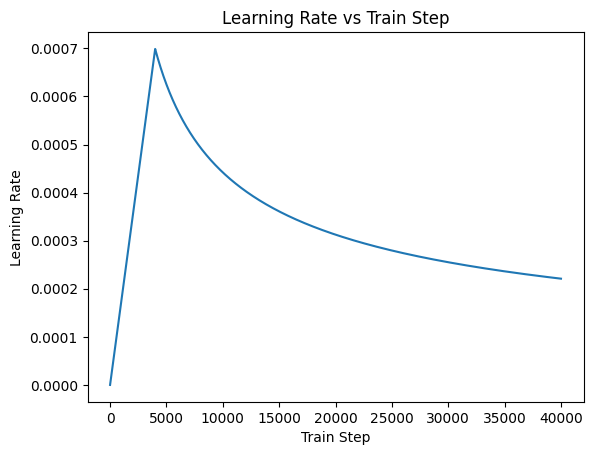

In [629]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, dim_model=D, warmup_steps=4000):
    super().__init__()

    self.dim_model = dim_model
    self.dim_model = tf.cast(self.dim_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return (tf.math.rsqrt(self.dim_model) * tf.math.minimum(arg1, arg2))

# create optimizer
learning_rate = CustomSchedule(dim_model=D)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# plot learning rate
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.title('Learning Rate vs Train Step')
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

# make batches
train_len = 132800
val_len = 14784
test_len = val_len
train_inputs = tab_inputs[:train_len]
train_outputs = chord_outputs[:train_len]
val_inputs = tab_inputs[train_len:train_len+val_len]
val_outputs = chord_outputs[train_len:train_len+val_len]
print('Training inputs: ' + str(train_inputs))
print()
print('Training outputs: ' + str(train_outputs))
print()
test_inputs = tab_inputs[train_len+val_len:train_len+val_len+test_len]
test_outputs = chord_outputs[train_len+val_len:train_len+val_len+test_len]

# define loss and accuracy functions
def c_loss(truths, preds):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
  c_truths = []
  c_preds = []
  for i in range(batch_size):
    c_truths.append(truths[i][0])
    c_preds.append(preds[i][0])
  c_preds = tf.stack(c_preds)
  c_truths = tf.stack(c_truths)
  loss = tf.reduce_sum(loss_object(c_truths, c_preds))
  return loss

def s_loss(truths, preds):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
  s_truths = []
  s_preds = []
  for i in range(batch_size):
    s_truths.append(truths[i][1])
    s_preds.append(preds[i][1])
  s_preds = tf.stack(s_preds)
  s_truths = tf.stack(s_truths)
  loss = tf.reduce_sum(loss_object(s_truths, s_preds))
  return loss

def f_loss(truths, preds):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
  f_truths = []
  f_preds = []
  for i in range(batch_size):
    f_truths.append(truths[i][2])
    f_preds.append(preds[i][2])
  f_preds = tf.stack(f_preds)
  f_truths = tf.stack(f_truths)
  loss = tf.reduce_sum(loss_object(f_truths, f_preds))
  return loss

def loss(truths,preds):
  return tf.add(tf.add(c_loss(truths,preds), s_loss(truths,preds)), f_loss(truths,preds))

def chord_accuracy(truths, preds):
  csf_preds = tf.argmax(preds,2)
  token_preds = [tokenize(csf_preds[i]) for i in range(batch_size)]
  token_truths = [tokenize(truths[i]) for i in range(batch_size)]
  token_preds = tf.cast(token_preds, tf.int32)
  token_truths = tf.cast(token_truths, tf.int32)
  match = token_truths == token_preds
  match = tf.cast(match, dtype=tf.int32)
  return tf.reduce_sum(match)/tf.size(match)

# compile model
tab2chord.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])

### tab2chord training

In [630]:
# train model
tab2chord.fit(train_inputs, train_outputs, batch_size = batch_size, epochs = epochs, validation_data = (val_inputs, val_outputs))

Epoch 1/20
4150/4150 [==============================] - 251s 58ms/step - loss: 59.2284 - accuracy: 0.7074 - val_loss: 91.4716 - val_accuracy: 0.5118
Epoch 2/20
4150/4150 [==============================] - 237s 57ms/step - loss: 78.8868 - accuracy: 0.5559 - val_loss: 76.1721 - val_accuracy: 0.5668
Epoch 3/20
4150/4150 [==============================] - 236s 57ms/step - loss: 76.9184 - accuracy: 0.5615 - val_loss: 75.9650 - val_accuracy: 0.5623
Epoch 4/20
4150/4150 [==============================] - 236s 57ms/step - loss: 76.0578 - accuracy: 0.5688 - val_loss: 75.3672 - val_accuracy: 0.5707
Epoch 5/20
4150/4150 [==============================] - 235s 57ms/step - loss: 66.2751 - accuracy: 0.6272 - val_loss: 54.8518 - val_accuracy: 0.6781
Epoch 6/20
4150/4150 [==============================] - 235s 57ms/step - loss: 56.3148 - accuracy: 0.6871 - val_loss: 52.2189 - val_accuracy: 0.7014
Epoch 7/20
4150/4150 [==============================] - 239s 58ms/step - loss: 52.2457 - accuracy: 0.7231 

In [631]:
# save the weights
tab2chord.save_weights('/content/drive/My Drive/Colab/tab2chord')

### tab2chord testing

In [632]:
# upload model weights
temp_model = Tab2Chord()
temp_model.load_weights('/content/drive/My Drive/Colab/tab2chord')
print()

# test accuracy on arbitrary batch of input tabs
idx = 2 # random
preds = temp_model(tf.convert_to_tensor(tab_inputs[idx:idx+batch_size], dtype=tf.int32))
truths = chord_outputs[idx:idx+batch_size]
print('The model is ' + str(100*chord_accuracy(truths,preds).numpy()) + '% accurate classifying the chord of tab ' + str(idx) + ' to ' + str(idx+batch_size))
print()

# test specific input sequence
print('tab2chord test:')
print()
idx = 287 # random
print('Test input: ' + str(tab_inputs[idx].numpy()))
print('Chord csf label: ' + str(chord_outputs[idx].numpy()))
print()
print('Output corresponds to ' + chord2name(chord_outputs[idx]))
print()
chord = temp_model(tf.convert_to_tensor(tab_inputs[idx:idx+batch_size], dtype=tf.int32))
c = chord[0][0]
s = chord[0][1]
f = chord[0][2]
print('tab2chord softmax output: ')
print('color: ' + str(c))
print('shape: ' + str(s))
print('fret: ' + str(f))
print()
print('tab2chord guess: ' + str([int(tf.math.argmax(c)), int(tf.math.argmax(s)), int(tf.math.argmax(f))]))
print('guess corresponds to ' + chord2name([int(tf.math.argmax(c)), int(tf.math.argmax(s)), int(tf.math.argmax(f))]))
print()
print('True output is ' + chord2name(chord_outputs[idx:idx+batch_size][0]))
print()

# test model on user-defined tab
tab = [mute_token,3,5,5,5,3]
print('User-defined tab: ' + str(tab))
print()
soft = temp_model(tf.convert_to_tensor([tab for i in range(batch_size)], dtype=tf.int32))
c = soft[0][0]
s = soft[0][1]
f = soft[0][2]
print('tab2chord softmax output: ')
print('color: ' + str(c))
print('shape: ' + str(s))
print('fret: ' + str(f))
print('tab2chord guess: ' + str([int(tf.math.argmax(c)), int(tf.math.argmax(s)), int(tf.math.argmax(f))]))
print('guess corresponds to ' + chord2name([int(tf.math.argmax(c)), int(tf.math.argmax(s)), int(tf.math.argmax(f))]))
print()

temp_model.summary()

The model is 71.875% accurate classifying the chord of tab 2 to 34

tab2chord test:

Test input: [12 14 14 12 12 12]
Chord csf label: [ 1  3 12]

Output corresponds to Em

tab2chord softmax output: 
color: tf.Tensor(
[4.7416416e-01 5.2583587e-01 1.6635697e-18 1.8877916e-18 1.8736867e-18
 1.8508263e-18 2.0012512e-18 1.9517924e-18 2.1205346e-18 2.3660333e-18
 2.2005198e-18 1.8177720e-18 1.8752811e-18 2.2580467e-18 1.9185003e-18], shape=(15,), dtype=float32)
shape: tf.Tensor(
[3.9926985e-05 7.8239515e-03 1.4548791e-09 9.9207389e-01 6.2156978e-05
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00], shape=(15,), dtype=float32)
fret: tf.Tensor(
[4.3651936e-15 1.6945510e-18 7.5202361e-13 5.6708696e-09 4.8122430e-04
 1.3103572e-10 1.3365702e-06 3.4510017e-10 1.5209757e-09 1.4820701e-05
 3.6267755e-07 3.3705842e-04 9.9854314e-01 6.2210113e-04 1.6458035e-16], shape=(15,), dtype=float32)

tab2chord guess: [